# Sentiment Analysis of Text Messages

Name: Rustom Ichhaporia

netID: rustomi2

In [13]:
import pandas as pd
import numpy as np
import sqlite3
import helper
import nltk
import string
import re
import os
import json

import matplotlib.pyplot as plt
import phonenumbers

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
sns.set()

In [16]:
# Please set these variables to False if you want to exclude one of the sources from the analysis
enable_imessage = True
enable_facebook = True

In [5]:
df = pd.DataFrame()

# Check if pickle file exists
if os.path.exists('./imessage.pkl'):
    imessage = pd.read_pickle('imessage.pkl')
else:
    # Path to iMessage database on MacOS
    imessage_path = '/Users/rustomichhaporia/Library/Messages/chat.db'
    imessage_raw = helper.read_messages(imessage_path, n=None)

    # Convert list of tuples to dataframe
    imessage = pd.DataFrame.from_records(imessage_raw, columns =['row_id', 'date', 'body', 'phone_number', 'is_from_me', 'cache_roomname', 'group_chat_name'])
    imessage = imessage.drop(['row_id', 'cache_roomname', 'group_chat_name'], axis=1)
    imessage = imessage.rename(columns={'date': 'timestamp', 'body': 'message'})

    # Convert timestamp to datetime
    imessage['timestamp'] = pd.to_datetime(imessage['timestamp'])

    # Remove messages from invalid phone number addresses. For the purposes of joining with my contacts, I ignored messages from email addresses and non-phone number addresses, but this can be changed to accomodate those addresses.
    imessage = imessage[~imessage.phone_number.str.contains('@')]
    imessage = imessage[~imessage.phone_number.str.contains('urn')]
    imessage = imessage[imessage.phone_number.str.len() > 7]

    # Remove duplicate entries
    imessage = imessage.drop_duplicates()

    # Pickle data for faster access later 
    imessage.to_pickle('imessage.pkl')

In [11]:
# IMPORTANT: Please change the following line and replace it with the path to your contacts database on MacOS. 
# It should be the folder with the most storage in the `.../Sources/` folder, if you use iCloud contacts.
contacts_folder = 'BFD08200-6674-4373-8DDB-8DB8D7FB1A7D'
homedir = os.path.expanduser('~')
contacts_path = os.path.join(homedir, 'Library/Application Support/AddressBook/Sources/', contacts_folder, 'AddressBook-v22.abcddb')

# Function to standardize the format of phone numbers in iMessage and iCloud contacts
def format_number(x):
    try:
        return phonenumbers.format_number(phonenumbers.parse(x, 'US'), num_format=phonenumbers.PhoneNumberFormat.INTERNATIONAL)
    except:
        return x

# Check if pickle file exists
if os.path.exists('./contacts.pkl'):
    contacts = pd.read_pickle('contacts.pkl')
else:
    conn = sqlite3.connect(contacts_path)
    cursor = conn.cursor()

    query = '''
    select ZABCDPHONENUMBER.ZFULLNUMBER, ZFIRSTNAME || ' ' || ZLASTNAME
    from ZABCDPHONENUMBER
    left join ZABCDRECORD
    on ZABCDPHONENUMBER.ZOWNER = ZABCDRECORD.Z_PK
    '''

    contacts = pd.DataFrame(cursor.execute(query).fetchall(), columns=['phone_number', 'name'])
    contacts['phone_number'] = contacts.phone_number.apply(lambda x: format_number(x))
    
    contacts.to_pickle('contacts.pkl')


imessage['phone_number'] = imessage.phone_number.apply(lambda x: format_number(x))
imessage = imessage.merge(contacts, how='left', on='phone_number')

In [14]:
# Change this to the path to your Facebook data
# It should contain at least one folder labeled your_activity_across_facebook... with an inbox folder inside
rootdir = './facebook-data'

# Change this to your name on Facebook
my_facebook_name = 'Rustom Ichhaporia'

if os.path.exists('./facebook.pkl'):
    facebook_df = pd.read_pickle('facebook.pkl')
else:
    facebook_df = pd.DataFrame()

    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file.startswith('message') and file.endswith('.json'):
                if 'inbox' not in subdir:
                    continue
                temp_path = os.path.join(subdir, file)
                temp = json.load(open(temp_path))

                # Remove groupchats and deleted chats and message requests
                if len(temp['participants']) > 2 or temp['title'] == '': 
                    continue
                
                temp_df = pd.DataFrame(temp['messages']).rename(columns={'sender_name': 'name', 'timestamp_ms': 'timestamp', 'content': 'message'})
                
                # Handle case where conversation only includes images
                if 'message' not in temp_df.columns:
                    continue

                temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'], unit='ms')
                temp_df['is_from_me'] = temp_df.name == my_facebook_name
                temp_df = temp_df[['timestamp', 'message', 'name', 'is_from_me']]
                temp_df['phone_number'] = ''
                temp_df['name'] = temp['title']
                facebook_df = pd.concat([facebook_df, temp_df]).reset_index(drop=True)

    facebook_df = facebook_df[facebook_df.message != '']
    facebook_df = facebook_df.drop_duplicates()
    facebook_df.to_pickle('facebook.pkl')

In [17]:
df = pd.DataFrame()

if os.path.exists('./all.pkl'):
    df = pd.read_pickle('all.pkl')

    df = df.sort_values(by='timestamp').reset_index(drop=True)
    df = df.drop_duplicates()
else:
    if enable_imessage:
        df = pd.concat([df, imessage]).reset_index(drop=True)
    if enable_facebook:
        df = pd.concat([df, facebook_df]).reset_index(drop=True)

    df = df.sort_values(by='timestamp').reset_index(drop=True)
    df = df.drop_duplicates()

    df.to_pickle('all.pkl')

df['name'] = df.name.astype(str)

In [18]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# This is an optional preprocessing function for text data if you would like to use it on other models. 
# The Vader Sentiment Analyzer has this preprocessing step built in. 
preprocess = False
if preprocess:
    lemmatizer = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    def preprocess(text):
        # Tokenize words
        tokens = nltk.word_tokenize(text)
        # Convert to lower case
        tokens = [word.lower() for word in tokens]
        # Remove punctuation and stopwords
        tokens = [token for token in tokens if token not in string.punctuation and token not in stopwords]
        # Remove URLS
        url_pattern = r"(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
        tokens = [token for token in tokens if not re.match(url_pattern, token)]
        # Lemmatize words
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(tokens)

    df['message'] = df.message.apply(lambda x: preprocess(x))

In [19]:
# Adjust the number below to change the number of top contacts to include in the analysis. 
n_top_names = 100
included_names = pd.Series(df.groupby('name').count().sort_values(by='message', ascending=False).head(n_top_names).index)
df = df[df['name'].isin(included_names)]

In [20]:
df['message_length'] = df.message.str.len()

# Employ the Vader Sentiment Analyzer to calculate the positive/negative compound sentiment of each message, ranging from -1 to 1
analyzer = SentimentIntensityAnalyzer()
df['compound_sentiment'] = df.message.astype(str).apply(lambda x: analyzer.polarity_scores(x)['compound'])

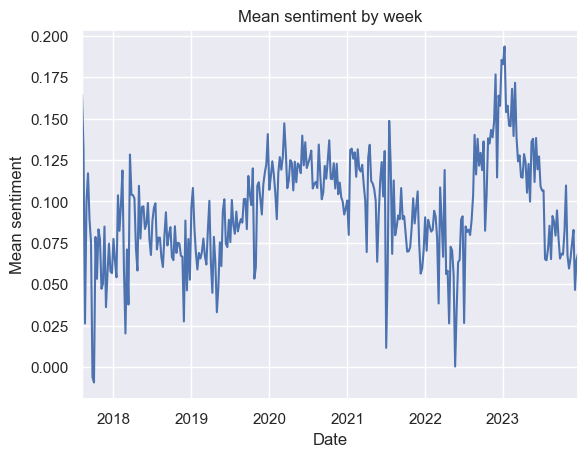

In [21]:
df.groupby(pd.Grouper(freq='W', key='timestamp')).compound_sentiment.mean().plot()
plt.xlabel('Date')
plt.ylabel('Mean sentiment')
plt.title('Mean sentiment by week')
plt.show()

<AxesSubplot: xlabel='compound_sentiment', ylabel='Density'>

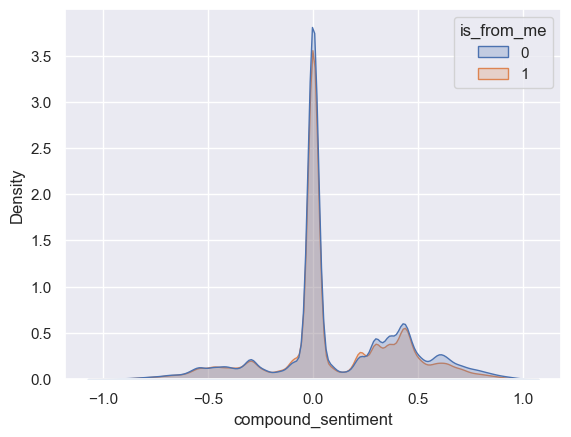

In [22]:
sns.kdeplot(x='compound_sentiment', hue='is_from_me', fill=True, data=df)

In [23]:
name_groupby = df.groupby('name').agg(num_messages=('compound_sentiment', 'size'), mean_compound_sentiment=('compound_sentiment', 'mean'), mean_message_length=('message_length', 'mean'), proportion_from_me=('is_from_me', 'mean')).reset_index()

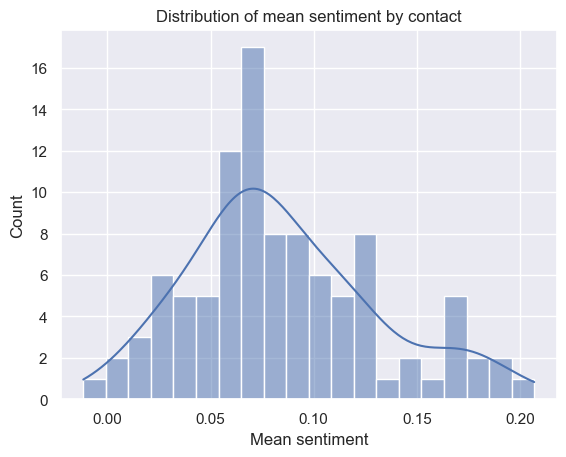

In [24]:
sns.histplot(name_groupby.mean_compound_sentiment, kde=True, bins=20)
plt.xlabel('Mean sentiment')
plt.ylabel('Count')
plt.title('Distribution of mean sentiment by contact')
plt.show()

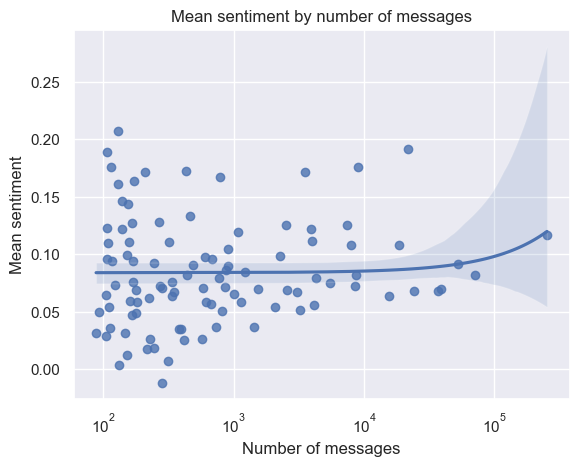

In [25]:
sns.regplot(x='num_messages', y='mean_compound_sentiment', data=name_groupby)
plt.xscale('log')
plt.xlabel('Number of messages')
plt.ylabel('Mean sentiment')
plt.title('Mean sentiment by number of messages')
plt.show()

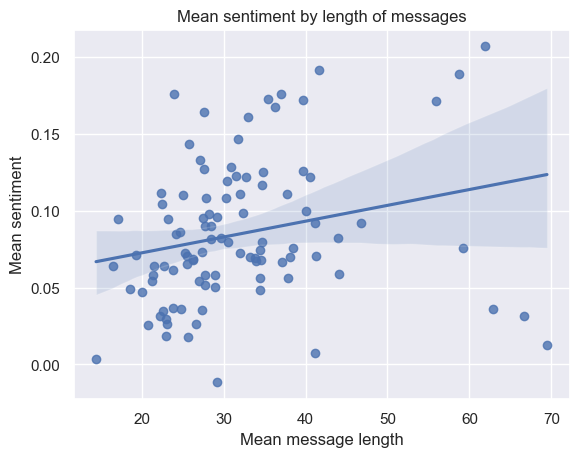

In [26]:
sns.regplot(x='mean_message_length', y='mean_compound_sentiment', data=name_groupby)
plt.xlabel('Mean message length')
plt.ylabel('Mean sentiment')
plt.title('Mean sentiment by length of messages')
plt.show()

<AxesSubplot: xlabel='proportion_from_me', ylabel='mean_compound_sentiment'>

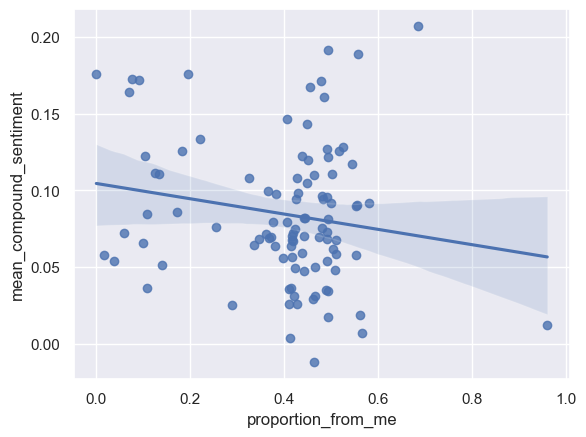

In [27]:
sns.regplot(x='proportion_from_me', y='mean_compound_sentiment', data=name_groupby)

<AxesSubplot: xlabel='proportion_from_me', ylabel='mean_message_length'>

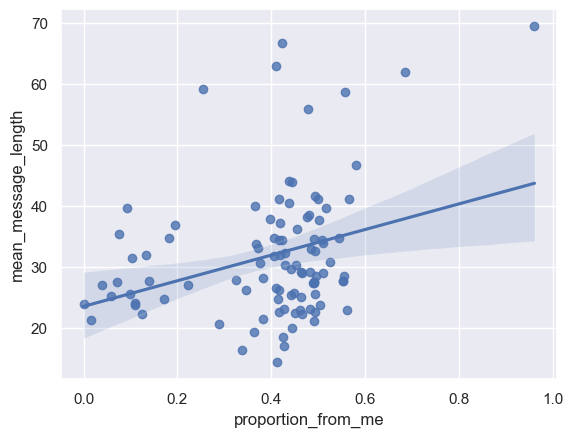

In [28]:
sns.regplot(x='proportion_from_me', y='mean_message_length', data=name_groupby)

In [39]:
# name_groupby[name_groupby.num_messages > 100].sort_values(by='mean_compound_sentiment', ascending=False)

There are many more interesting analyses that can be conducted using this data pipeline. Unfortunately, the brunt of the work was the data processing as opposed to the modeling, so I did not have time to explore more types of modeling.